In [2]:
import sem
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

# Create our SEM campaign
ns_3_dir = '../../../../'
script = 'aloha-throughput'
results_dir = 'aloha-results'
campaign = sem.CampaignManager.new(ns_3_dir, script, results_dir,
                                   check_repo=False, overwrite=True,skip_configuration=True)

# Define the parameter space we are interested in exploring
params = {
    'nDevices': [100],
    'simulationTime':  [round(i, 4) for i in np.logspace(0.5, 2, base=60, num=100, dtype='float')],
    'radius': [7500],
    'interferenceMatrix': ["aloha"] #lambda p: ["aloha"] if p["radius"] == 0 else ["goursaud"],
}

runs = 50

# Run simulations with the above parameter space
campaign.run_missing_simulations(params, runs)

DRMAA_AVAILABLE: False
Runner Type is : ParallelRunner


Running simulations: 100%|██████████| 5000/5000 [01:13<00:00, 68.13simulation/s]


In [3]:
example_result = campaign.db.get_complete_results()[0]
display(example_result)
print(sem.utils.get_command_from_result('aloha-throughput', example_result))

{'params': {'nDevices': 100,
  'simulationTime': 633.7753,
  'radius': 7500,
  'interferenceMatrix': 'aloha',
  'RngRun': 3579},
 'meta': {'id': 'f4b876e5-3f5a-4a0a-9102-cec9c1b1ff07',
  'elapsed_time': 0.08789348602294922,
  'exitcode': 0},
 'output': {'durations.txt': '112896 205312 369664 657408 1478656 2629632 ',
  'stderr': '',
  'stdout': '19 14\n9 8\n7 4\n13 9\n16 10\n36 24\n'}}

python3 waf --run "aloha-throughput --nDevices=100 --simulationTime=633.7753 --radius=7500 --interferenceMatrix=aloha --RngRun=3579"


In [4]:
@sem.utils.output_labels(['G', 'S'])
def get_throughput(result):
    """
    Extract the probability of success from the simulation output
    """
    durations = [float(i)/1e6 for i in result['output']['durations.txt'].split()]
    sent = 0
    g = 0
    s = 0
    sf = 7
    for sf_performance in result['output']['stdout'].splitlines():
        sent, received = [float(i) for i in sf_performance.split()]
        current_g = sent * durations[sf-7] / result['params']['simulationTime']
        g += current_g
        if sent == 0:
            s += 0
        else:
            s += current_g * received / sent
        sf += 1
    return [g, s]

In [6]:
results = campaign.get_results_as_dataframe(get_throughput,
                                            params=params)
print(results)

      nDevices  simulationTime  radius interferenceMatrix  RngRun          G  \
0          100           7.746    7500              aloha      12  18.948429   
1          100           7.746    7500              aloha       7  20.507067   
2          100           7.746    7500              aloha      41  21.071285   
3          100           7.746    7500              aloha      48  19.963208   
4          100           7.746    7500              aloha      47  22.968184   
...        ...             ...     ...                ...     ...        ...   
4995       100        3600.000    7500              aloha    4968   0.038312   
4996       100        3600.000    7500              aloha    4995   0.041006   
4997       100        3600.000    7500              aloha    4952   0.038902   
4998       100        3600.000    7500              aloha    4970   0.037947   
4999       100        3600.000    7500              aloha    4980   0.042958   

             S  
0     0.041080  
1    

In [ ]:
results = results.join(results.groupby(list(params.keys()))['G'].mean(), on=list(params.keys()), rsuffix='_avg')

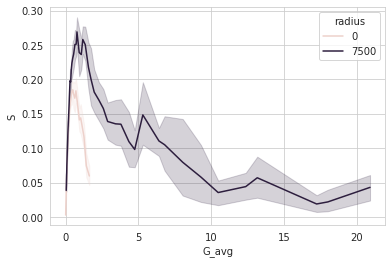

In [ ]:
sns.lineplot(data=results,
            x='G_avg', 
            y='S',
            hue='radius')

plt.show()